# Computational Economics: Optimization I


Florian Oswald
Sciences Po, 2019

* This lecture reminds you of some optimization theory.
* The focus here is to illustrate use cases with julia.
* We barely scratch the surface of optimization, and I refer you to Nocedal and Wright for a more thorough exposition in terms of theory.
* This 2-part lecture is heavily based on [Algorithms for Opimization](https://mitpress.mit.edu/books/algorithms-optimization) by Kochenderfer and Wheeler.

This is a 2 part lecture.

### Optimization I: Basics

1. Intro
2. Conditions for Optima
3. Derivatives and Gradients
4. Numerical Differentiation
5. JuliaOpt

### Optimization II: Algorithms

1. Bracketing
2. Local Descent
3. First/Second Order and Direct Methods
4. Constraints


## The Optimization Process

```
1. Problem Specification
2. Initial Design
3. Optimization Proceedure:
    a) Evaluate Performance
    b) Good?
        i. yes: final design
        ii. no: 
            * Change design
            * go back to a)
```            

We want to automate step 3.



## Optimization Algorithms

* All of the algorithms we are going to see employ some kind of *iterative* proceedure. 
* They try to improve the value of the objective function over successive steps.
* The way the algorithm goes about generating the next step is what distinguishes algorithms from one another.
	* Some algos only use the objective function
	* Some use both objective and gradients
	* Some add the Hessian
	* and many variants more

## Desirable Features of any Algorithm

* Robustness: We want good performance on a wide variety of problems in their class, and starting from *all* reasonable starting points.
* Efficiency: They should be fast and not use an excessive amount of memory.
* Accuracy: They should identify the solution with high precision.



## A Word of Caution

* You should **not** normally attempt to write a numerical optimizer for yourself.
* Entire generations of Applied Mathematicians and other numerical pro's have worked on those topics before you, so you should use their work.
	* Any optimizer you could come up with is probably going to perform below par, and be highly likely to contain mistakes.
	* Don't reinvent the wheel.
* That said, it's very important that we understand some basics about the main algorithms, because your task is **to choose from the wide array of available ones**.

## Optimisation Basics

* Recall our generic definition of an optimization problem:

$$ 
\min_{x\in\mathbb{R}^n} f(x)  \text{ s.t. } x \in \mathcal{X}
$$

* $x$ is our *choice variable* or a *design point*.
* $\mathcal{X}$ is the feasible set.
* $f$ is the *objective function*
* A vector $x^*$ is a *solution* or a *minimizer* to this problem if $x^*$ is *feasible* and $x^*$ minimizes $f$.
* Maximization is just minimizing $(-1)f$:

$$ 
\min_{x\in\mathbb{R}^n} f(x)  \text{ s.t. } x \in \mathcal{X} \equiv \max_{x\in\mathbb{R}^n} -f(x)  \text{ s.t. } x \in \mathcal{X} 
$$

## Local Solutions

* Keep in mind that there may be other (better!) solutions outside of your interval of attention.

![](../assets/figs/optimization/local-min.png)

## Constraints

* We often have constraints on problems in economics.

$$ 
\max_{x_1,x_2} u(x_1,x_2)  \text{ s.t. } p_1 x_1 + p_2 x_2 \leq y
$$

* Constraints define the feasible set $\mathcal{X}$.
* It's better to write *weak inequalities* (i.e. $\leq$) rather than strict ones ($<$). 

## Critical Points

* A given univariate function can exhibit several *critical points* i.e. points where the derivative is zero (as we'll see). 
* Ideally we would like to find a *global minimum*. However, that's not always straightforward to do.
* Most of the times, the best we can do is check for a *local minimum*

![](../assets/figs/optimization/critical-points.png)

## Conditions for Local Minima

We can define *first and second order necessary conditions*, FONC and SONC. This definition is to point out that those conditions are not sufficient for optimality (only necessary).

### Univariate $f$

1. **FONC:** $f'(x^*) =0$
2. **SONC** $f''(x^*) \geq 0$ (and $f''(x^*) \leq 0$ for local maxima)
2. (**SOSC** $f''(x^*) > 0$ (and $f''(x^*) < 0$ for local maxima))

### Multivariate $f$

1. **FONC:** $\nabla f(x^*) =0$
2. **SONC** $\nabla^2f(x^*)$ is positive semidefinite (negative semidefinite for local maxima)
2. (**SOSC** $\nabla^2f(x^*)$ is positive definite (negative definite for local maxima))

In [1]:
using Plots
gr()  # used to choose plotlyjs backend, but does not survive html export...
v=collect(range(-2,stop = 2, length = 30))  # values
mini = [x^2 + y^2 for x in v, y in v]
maxi = -mini   # max is just negative min
saddle = [x^2 + y^3 for x in v, y in v];

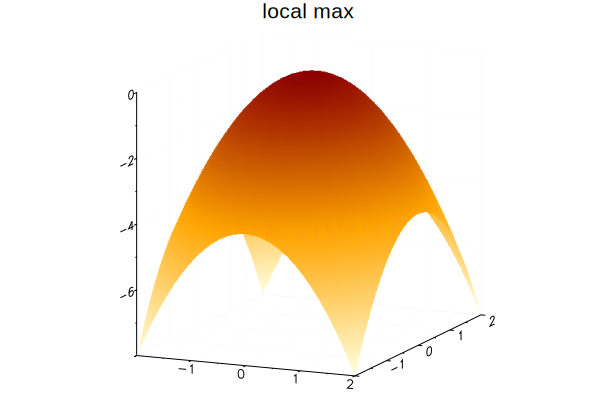

In [3]:
surface(v,v,maxi,title="local max",fillalpha=0.5,leg=false,fillcolor=:heat)

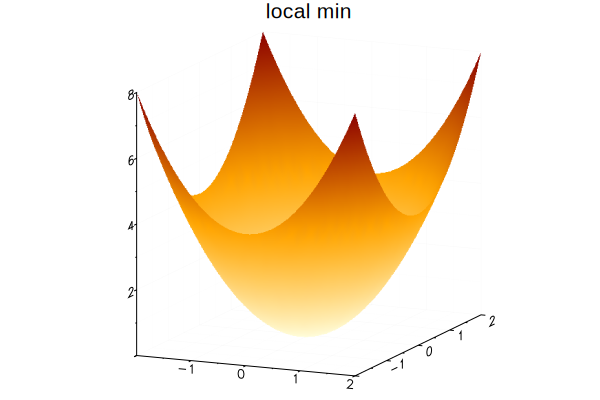

In [4]:
surface(v,v,mini,title="local min",fillalpha=0.5,leg=false,fillcolor=:heat)

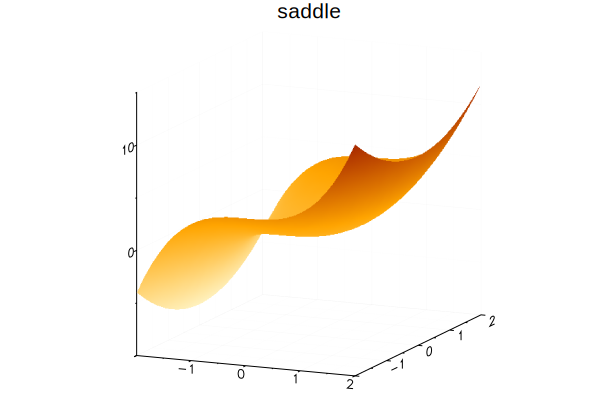

In [5]:
surface(v,v,saddle,title="saddle",fillalpha=0.7,leg=false,fillcolor=:heat)

## Example Time: Rosenbrock's Banana Function

A well-known test function for numerical optimization algorithms is the Rosenbrock banana function developed by Rosenbrock in 1960. it is defined by 

$$ f(\mathbf{x}) = (1-x_1)^2  + 5(x_2-x_1^2)^2  $$
    

In [6]:
# let's get a picture of this
rosenbrock(x; a=1, b=5) = (a-x[1])^2 + b*(x[2] - x[1]^2)^2
x=y=collect(range(-2,stop = 2, length = 100))  # x and y axis
f = [rosenbrock([ix,iy]) for ix in x, iy in y]  # f evaluations

# plotting
wireframe(x,y,f,linecolor=:grey)
surface!(x,y,f,fillcolor=:darkrainbow,colorbar=false)

### Analysing the Rosenbrock function

$$f(\mathbf{x}) = (1-x_1)^2  + 5(x_2-x_1^2)^2$$

* Is the point $(1,1)$ satisfying FONC and SONC?
* Let's write down gradient and hessian to find out!


## Derivatives and Gradients

* The derivative of a univariate function $f$ at point $x$, $f'(x)$ gives the rate at which $f$ changes at $x$.
* Think of a tangent line to a curve.
* There are three different ways to present $f'$: forward difference, central difference, and backward difference:
	$$ f'(x) \equiv \underbrace{\lim_{h\to0}\frac{f(x+h)-f(x)}{h}}_{\text{forward diff}}= \underbrace{\lim_{h\to0}\frac{f(x+h/2)-f(x-h/2)}{h}}_{\text{central diff}}=\underbrace{\lim_{h\to0}\frac{f(x)-f(x-h)}{h}}_{\text{backward diff}}$$



## Symbolic Differentiation on a Computer

* If you can write down an analytic form of $f$, there are ways to *symbolically* differentiate it on a computer.
* This is as if you would do the derivation on paper.
* Mathematica, python, and julia all have packages for that.
* While this works well, most of the times we don't have an analytic $f$.

In [6]:
using SymEngine
x = symbols("x");
f = x^2 + x/2 - sin(x)/x; diff(f, x)

1/2 + 2*x + sin(x)/x^2 - cos(x)/x

## Multiple Dimensions: Gradients

* Unless otherwise noted, we have $x \in \mathbb{R}^n$ as an $n$ element vector.
* The **gradient** of a function $f : \mathbb{R}^n \mapsto \mathbb{R}$ is denoted $\nabla f:\mathbb{R}^n \mapsto \mathbb{R}^n$ and it returns a vector
	
$$ \nabla f(x) = \left(\frac{\partial f}{\partial x_1}(x),\frac{\partial f}{\partial x_2}(x),\dots,\frac{\partial f}{\partial x_n}(x) \right) $$
    




* It's **hessian** is a function denoted $\nabla^2 f(x)$ or $H_f :\mathbb{R}^n \mapsto \mathbb{R}^{n\times n}$ and returns an $(n,n)$ matrix given by
	
$$  
H_f(x) = \left( \begin{array}{cccc} 
\frac{\partial^2 f}{\partial x_1 \partial x_1}(x)  &  \frac{\partial^2 f}{\partial x_2 \partial x_1}(x) & \dots & \frac{\partial^2 f}{\partial x_n \partial x_1}(x) \\
\frac{\partial^2 f}{\partial x_1 \partial x_2}(x)  &  \frac{\partial^2 f}{\partial x_2 \partial x_2}(x) & \dots & \frac{\partial^2 f}{\partial x_n \partial x_2}(x) \\
\vdots & \vdots & \dots & \vdots \\
\frac{\partial^2 f}{\partial x_1 \partial x_n}(x)  &  \frac{\partial^2 f}{\partial x_2 \partial x_n}(x) & \dots & \frac{\partial^2 f}{\partial x_n \partial x_n}(x) 
\end{array}\right)
$$

* The **directional derivative** $\nabla_s f(\mathbf{x})$ is an important concept that we will re-encounter when talking about *gradient descent*.
* $\nabla_s f(\mathbf{x})$ tells us the rate of change in $f$ as we move through $\mathbf{x}$ at *velocity* $\mathbf{s}$
* It has similiar defintion
    $$\nabla_s f(\mathbf{x}) \equiv \underbrace{\lim_{h\to0}\frac{f(\mathbf{x}+h\mathbf{s})-f(\mathbf{x})}{h}}_{\text{forward diff}}= \underbrace{\lim_{h\to0}\frac{f(\mathbf{x}+h/2\mathbf{s})-f(\mathbf{x}-h/2\mathbf{s})}{h}}_{\text{central diff}}=\underbrace{\lim_{h\to0}\frac{f(\mathbf{x})-f(\mathbf{x}-h\mathbf{s})}{h}}_{\text{backward diff}}$$
* We can use the gradient $\nabla f(\mathbf{x})$ to compute it:
    $$\nabla_\mathbf{s} f(\mathbf{x}) = \nabla f(\mathbf{x})^\top \mathbf{s}$$

* For example, let's compute it for $f(\mathbf{x}) = x_1 x_2$ at $\mathbf{x} = [2, 0]$ in direction $\mathbf{s}=[-1,-1]$

    $$
    \begin{aligned}
    \nabla f(\mathbf{x}) & = \left[ ,\frac{\partial f(\mathbf{x})}{\partial x_1},\frac{\partial f(\mathbf{x})}{\partial x_2} \right] = [x_2,x_1 ] \\
    \nabla_\mathbf{s} f(\mathbf{x}) & = \nabla f(\mathbf{x})^\top \mathbf{s} = \left[\begin{array}{cc}0& 2\end{array}\right] \left[\begin{array}{c}-1\\-1\end{array} \right] = -2
    \end{aligned}
    $$


    
    

## Numerical Differentiation

* In most cases we have to compute the derivative numerically. There are 2 strategies:
1. Finite Differences
2. Automatic Differentiation



### Finite Differences

The idea here is to literally take our definition for a derivative from above, and compute it for small $h$:
$$ f'(x) \approx \underbrace{\frac{f(x+h)-f(x)}{h}}_{\text{forward diff}}= \underbrace{\frac{f(x+h/2)-f(x-h/2)}{h}}_{\text{central diff}}=\underbrace{\frac{f(x)-f(x-h)}{h}}_{\text{backward diff}}$$

* The central difference has a quadratic error, as opposed to the forward difference method, hence it's often preferrable
* There is however the problem of numerical instability due to a *too small* $h$.
* The *complex step method* takes a step in an imaginary direction to bypass this:
$$ f'(x) = \frac{\text{Im}(f(x+ih))}{h} + O(h^2) \text{ as }h\to \infty $$

### Finite Differences: what's the right step size $h$?

* Theoretically, we would like to have $h$ as small as possible, since we want to approximate the limit at zero.
* In practice, on a computer, there is a limit to this. There is a smallest representable number, as we know.
* `eps()`.
* One can show that the optimal step size is $h=\sqrt{\texttt{eps()}}$

In [7]:
# the Calculus.jl package implements finite differences
using Calculus

derivative(x->x^2,1.0)  # standard signature of function
println("forward = $(Calculus.finite_difference(x->x^2,1.0,:forward))")
println("central = $(Calculus.finite_difference(x->x^2,1.0,:central))")
println("complex = $(Calculus.finite_difference(x->x^2,1.0,:complex))")
println("")
println("forward = $(Calculus.finite_difference( x->sin(x^2) ,π/2,:forward))")
println("central = $(Calculus.finite_difference( x->sin(x^2) ,π/2,:central))")
println("complex = $(Calculus.finite_difference( x->sin(x^2) ,π/2,:complex))")

forward = 2.000000014901161
central = 1.9999999999829379
complex = 2.0

forward = -2.45424963163794
central = -2.4542495409833656
complex = -2.4542495411512917


In [8]:
# also can compute gradients for multidim functions
Calculus.gradient(x->x[1]^2 * exp(3x[2]),ones(2))
Calculus.hessian(x->x[1]^2 * exp(3x[2]),ones(2))


2×2 Array{Float64,2}:
  40.171  120.513
 120.513  180.77 

In [9]:
# there is another problem apart from numerical issues with small h:
f1 = function(x)
    println("evaluation of f1")
    x[1]^2 * exp(3x[2])
end
Calculus.gradient(f1,ones(2))
    
# for an f that is expensive to compute, this method quickly becomes infeasible.

evaluation of f1
evaluation of f1
evaluation of f1
evaluation of f1


2-element Array{Float64,1}:
 40.17107384604091
 60.25661077199484

## Automatic Differentiation (AD)

* Breaks down the actual `code` that defines a function and performs elementary differentiation rules, after disecting expressions via the chain rule:
$$\frac{d}{dx}f(g(x)) = \frac{df}{dg}\frac{dg}{dx}$$
* This produces **analytic** derivatives, i.e. there is **no** approximation error.
* Very accurate, very fast.
* The idea is to be able to *unpick* **expressions** in your code.
* Let's look at an example


Consider the function $f(x,y) = \ln(xy + \max(x,2))$. Let's get the partial derivative wrt $x$:

$$ 
\begin{aligned} \frac{\partial f}{\partial x} &= \frac{1}{xy + \max(x,2)} \frac{\partial}{\partial x}(xy + \max(x,2)) \\
         &= \frac{1}{xy + \max(x,2)} \left[\frac{\partial(xy)}{\partial x} + \frac{\partial\max(x,2)}{\partial x} \right]\\
         &= \frac{1}{xy + \max(x,2)} \left[\left(y\frac{\partial(x)}{\partial x} + x\frac{\partial(y)}{\partial x}\right) + \left(\mathbf{1}(2>x)\frac{\partial 2}{\partial x} + \mathbf{1}(2<x)\frac{\partial x}{\partial x} \right)\right] \\
          &= \frac{1}{xy + \max(x,2)} \left[y + \mathbf{1}(2<x)\right]
\end{aligned}
 $$
 
 where the indicator function $\mathbf{1}(r)=1$ if $r$ evaluates to *true*, 0 otherwise.
 


* What we just did here, i.e. unpacking the mathematical operation $\frac{\partial f}{\partial x}$ can be achieved by a computer using a *computational graph*. 
* Automatic Differentiation traverses the computational graph of an *expression* either forwards (in *forward accumulation* mode), or backwards (in *reverse accumulation* mode).

This can be illustrated in a **call graph** as below:
* circles denote operators
* arrows are input/output
* We want to unpack the expression by successively applying the chain rule:
    $$ \frac{d f}{d x} = \frac{d f}{d c_4}\frac{d c_4}{d x} = \frac{d f}{d c_4}\left(\frac{d c_4}{d c_3}\frac{d c_3}{d x}\right) = \frac{d f}{d c_4}\left(\frac{d c_4}{d c_3}\left(\frac{d c_3}{d c_2}\frac{d c_2}{d x}\right)\right) = \dots $$
* Here is our operation $f(x,y)$ described as a call graph:

![](../assets/figs/optimization/callgraph.png)

### Accumulating *forwards* along the call graph

* Let's illustrate how AD in forward mode works for $x=3,y=2$ and the example at hand. Remember that
    $$f(x,y) = \ln(xy + \max(x,2))$$
    and, hence 
    $$f(3,2) = \ln( 6 + 3 ) = \ln 9 \text{  and  }\frac{\partial f}{\partial x} = \frac{1}{6 + 3}(2 + 1) = \frac{1}{3}$$
* We start at the left side of this graph with the inputs. 
* The key is for each quantity to compute both the value **and** it's partial derivative wrt $x$ in this case.



![](../assets/figs/optimization/callgraph1.png)

![](../assets/figs/optimization/callgraph2.png)

![](../assets/figs/optimization/callgraph3.png)

![](../assets/figs/optimization/callgraph4.png)

![](../assets/figs/optimization/callgraph5.png)

* Reverse mode works very similarly.
* So, we saw that AD yields both a function value ($c_4$) as well as a derivative ($\dot{c_4}$)
* They have the correct values.
* This procedure required a *single* pass forward over the computational graph.
* Notice that the **exact same amount of computation** needs to be performed by any program trying to evaluate merely the *function value* $f(3,2)$:
    1. multiply 2 numbers
    2. max of 2 numbers
    3. add 2 numbers
    4. natural logarithm of a number

QUESTION: **WHY HAVE WE NOT BEEN DOING THIS FOR EVER?!**
ANSWER: **Because it was tedious.**

### Implementing AD

* What do you need to implement AD?

1. We need what is called *dual numbers*. This is similar to complex numbers, in that each number has 2 components: a standard *value*, and a *derivative*
    * In other words, if $x$ is a dual number, $x = a + b\epsilon$ with $a,b \in \mathbb{R}$.
    * For our example, we need to know how to do *addition*, *multiplication*, *log* and *max* for such a number type:
    $$
    \begin{aligned}
    (a+b\epsilon) + (c+d\epsilon) &= (a+c) + (b+d\epsilon) \\
    (a+b\epsilon) \times (c+d\epsilon) &= (ac) + (ad+bd\epsilon)
    \end{aligned}
    $$
2. You need a programming language where *analyzing expressions* is not too difficult to do. you need a language that can do *introspection*.

### Implementing Dual Numbers in Julia

This is what it takes to define a `Dual` number type in julia:

```julia
struct Dual 
    v
    ∂
end

Base.:+(a::Dual, b::Dual) = Dual(a.v + b.v, a.∂ + b.∂) 
Base.:*(a::Dual, b::Dual) = Dual(a.v * b.v, a.v*b.∂ + b.v*a.∂) 
Base.log(a::Dual) = Dual(log(a.v), a.∂/a.v)
function Base.max(a::Dual, b::Dual)
    v = max(a.v, b.v)
    ∂ = a.v > b.v ? a.∂ : a.v < b.v ? b.∂ : NaN 
    return Dual(v, ∂)
end
function Base.max(a::Dual, b::Int) 
    v = max(a.v, b)
    ∂ = a.v > b ? a.∂ : a.v < b ? 1 : NaN
    return Dual(v, ∂) 
end
```

In [14]:
# ForwardDiff.jl is a julia package for ... Forward AD!
using ForwardDiff
x = ForwardDiff.Dual(3,1);
y = ForwardDiff.Dual(2,0);
log(x*y + max(x,2))

Dual{Nothing}(2.1972245773362196,0.3333333333333333)

### Analyzing Expressions

* Everything you type into julia is an `Expr`ession:

```julia
  mutable struct Expr <: Any

  Fields:

  head :: Symbol
  args :: Array{Any,1}
  typ  :: Any
```

In [11]:
println("create an explicit expression by `quoting` it with `:`")
expr = :(x + y)
println("typeof(expr)=$(typeof(expr))")

println("\ncan evaluate an expression")
x = 2;y=3
println(eval(expr))

println("\nand we can pick it apart:")
println("expr.head=$(expr.head)")
println("expr.args=$(expr.args)")

create an explicit expression by `quoting` it with `:`
typeof(expr)=Expr

can evaluate an expression
5

and we can pick it apart:
expr.head=call
expr.args=Any[:+, :x, :y]


In [12]:
# our example was 
ex = :(log(x*y + max(x,2)))
# we can access every piece of the call graph, e.g.
println("the first elemt of args is $(ex.args[1])")

println("let's dump the entire callgraph")
dump(ex)

the first elemt of args is log
let's dump the entire callgraph
Expr
  head: Symbol call
  args: Array{Any}((2,))
    1: Symbol log
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol *
            2: Symbol x
            3: Symbol y
        3: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol max
            2: Symbol x
            3: Int64 2


## (Unconstrained) Optimization in `Julia`

* Umbrella Organisation: [`http://www.juliaopt.org`](http://www.juliaopt.org)
	* We will make ample use of this when we talk about constrained optimsation.
	* The Julia Interface to the very well established [C-Library NLopt](http://ab-initio.mit.edu/wiki/index.php/NLopt) is called [`NLopt.jl`](https://github.com/JuliaOpt/NLopt.jl). One could use `NLopt` without constraints in an unconstrained problem.
* [`Roots.jl`](https://github.com/JuliaLang/Roots.jl): Simple algorithms that find the zeros of a univariate function.
* Baseline Collection of unconstrained optimization algorithms: [`Optim.jl`](https://github.com/JuliaOpt/Optim.jl)

## Introducing [`Optim.jl`](https://github.com/JuliaNLSolvers/Optim.jl)

* Multipurpose unconstrained optimization package 
	* provides 8 different algorithms with/without derivatives
	* univariate optimization without derivatives
    * It comes with the workhorse function `optimize`

In [1]:
# let's optimize rosenbrock's function without any gradient/hessian info:
using Optim
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = optimize(rosenbrock, zeros(2), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.9999999926033423,0.9999999852005353]
 * Minimum: 5.471433e-17
 * Iterations: 16
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.47e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.20e+03 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.33e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 53
 * Gradient Calls: 53

### now let's supply both hessian and gradient

* What are gradient and hessian of this function?
* Write them down on a piece of paper!

In [5]:
function g!(G, x)
           G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
           G[2] = 200.0 * (x[2] - x[1]^2)
end
function h!(H, x)
           H[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
           H[1, 2] = -400.0 * x[1]
           H[2, 1] = -400.0 * x[1]
           H[2, 2] = 200.0
end
optimize(rosenbrock, g!, h!, zeros(2), Newton())



Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.9999999999999994,0.9999999999999989]
 * Minimum: 3.081488e-31
 * Iterations: 14
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.06e-09 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.03e+13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.11e-15 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 44
 * Gradient Calls: 44
 * Hessian Calls: 14